In [1]:
import os
import pandas as pd
import numpy as np
import os
import pandas as pd
import numpy as np
from nilearn import image
from nilearn.input_data import NiftiSpheresMasker
import time
import sys

# parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results/roi_analysis'
raw_dir = params.raw_dir

# Load subject information
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
sub_info = sub_info[sub_info['group'] == 'control']
subs = sub_info['sub'].tolist()
rois = ['pIPS', 'LO']
hemispheres = ['left', 'right']
task = 'loc'

all_data = []

for sub in subs:
    for roi in rois:
        for hemi in hemispheres:
            file_path = f'{study_dir}/{sub}/ses-01/derivatives/roi_activations/{sub}_{roi}_{hemi}_{task}_roi_activation.csv'
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                mean_activation = df['mean_activation'].mean()
                all_data.append({
                    'subject': sub,
                    'roi': roi,
                    'hemisphere': hemi,
                    'mean_activation': mean_activation
                })

results_df = pd.DataFrame(all_data)

# Calculate group averages
group_averages = results_df.groupby(['roi', 'hemisphere'])['mean_activation'].mean().reset_index()

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
chart_data = []
for roi in rois:
    roi_data = {'roi': roi}
    for hemi in hemispheres:
        value = group_averages[(group_averages['roi'] == roi) & (group_averages['hemisphere'] == hemi)]['mean_activation'].values[0]
        roi_data[hemi] = value
    chart_data.append(roi_data)

print(chart_data)

[{'roi': 'pIPS', 'left': 10674.061263157893, 'right': 10216.69382982456}, {'roi': 'LO', 'left': 10772.343684210526, 'right': 10478.117524561403}]


/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


Plot has been saved as: /user_data/csimmon2/git_repos/ptoc/results/hemisphere_activation_by_roi.png


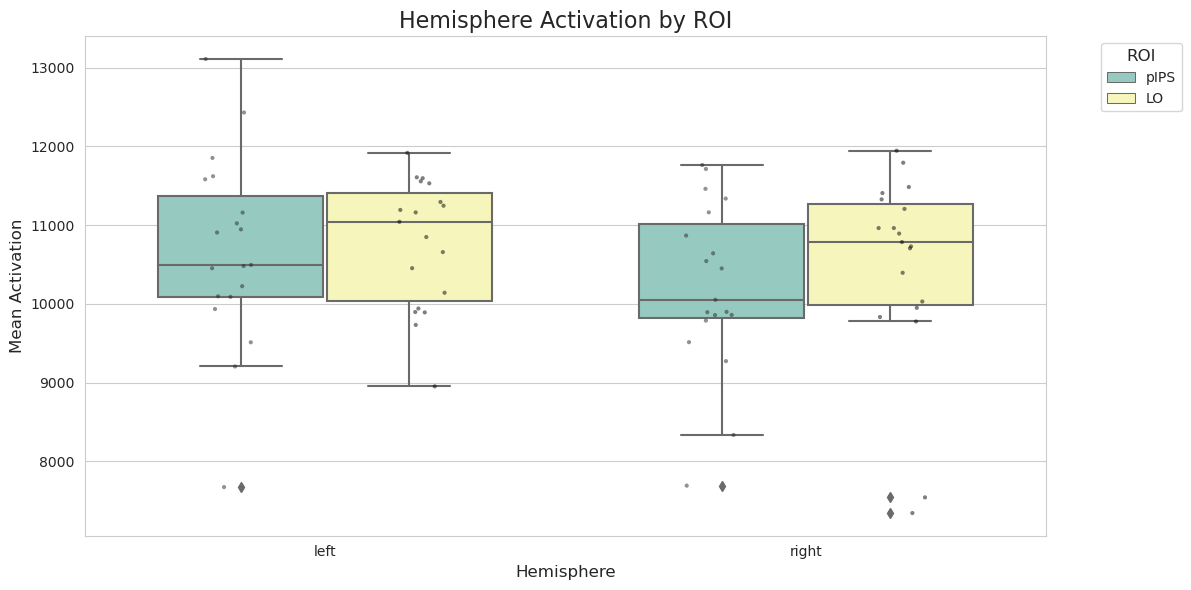

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up directories
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Load the data
data = results_df

# Set the color palette to match previous plots
color_palette = sns.color_palette("Set3")

# Create the plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create the box plot
sns.boxplot(x='hemisphere', y='mean_activation', hue='roi', 
            data=results_df, palette=color_palette[:2], width=0.7)

# Add individual data points
sns.stripplot(x='hemisphere', y='mean_activation', hue='roi', 
              data=results_df, dodge=True, alpha=0.5, 
              color='black', size=3)

# Customize the plot
plt.title('Hemisphere Activation by ROI', fontsize=16)
plt.xlabel('Hemisphere', fontsize=12)
plt.ylabel('Mean Activation', fontsize=12)

# Adjust legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title='ROI', title_fontsize='12', fontsize='10', 
           bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
output_path = os.path.join(results_dir, 'hemisphere_activation_by_roi.png')
#plt.savefig(output_path, dpi=300, bbox_inches='tight')
#plt.close()

print(f"Plot has been saved as: {output_path}")

In [17]:
import pandas as pd
import numpy as np
from plotnine import (ggplot, aes, geom_point, geom_linerange, theme_classic, 
                      ylim, xlab, ylab, theme, element_text, element_line, 
                      element_blank, scale_color_manual, position_dodge2, 
                      geom_hline, scale_shape_manual, labs)
import matplotlib.pyplot as plt
from scipy import stats

# Assuming results_df is already loaded and contains your data
# If not, uncomment and modify the following lines:
# results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
# results_df = pd.read_csv(f"{results_dir}/your_data_file.csv")

# Create a new column combining hemisphere and ROI
results_df['region'] = results_df['hemisphere'] + ' ' + results_df['roi']

# Create summary dataframe
summary_df = results_df.groupby('region').agg({
    'mean_activation': ['mean', 'sem']
}).reset_index()
summary_df.columns = ['region', 'mean', 'se']

# Ensure the regions are in the desired order (flipped LO and pIPS)
region_order = ['left pIPS', 'left LO', 'right pIPS', 'right LO']
summary_df['region'] = pd.Categorical(summary_df['region'], categories=region_order, ordered=True)
summary_df = summary_df.sort_values('region')

# Create the plot
plot = (ggplot(summary_df, aes(x='region', y='mean', color='region', shape='region'))
        + geom_linerange(aes(ymin='mean - se', ymax='mean + se'), 
                         size=1, position=position_dodge2(width=0.5))
        + geom_point(size=4, fill='white', stroke=1, 
                     position=position_dodge2(width=0.5))
        + scale_color_manual(values=['#31688E', '#440154', '#31688E', '#440154'])
        + scale_shape_manual(values=['o', 's', 'o', 's'])
        + theme_classic()
        + labs(color='Region', shape='Region')
        + xlab('Region')
        + ylab('Mean Activation')
        + theme(
            text=element_text(color='black'),
            axis_text_x=element_text(angle=45, hjust=1, size=12),
            axis_text_y=element_text(size=12),
            axis_title=element_text(size=14),
            axis_line=element_line(),
            panel_border=element_blank(),
            legend_position="none",
            figure_size=(10, 6)
        ))

# Save the plot
output_path = f"{results_dir}/hemisphere_activation_plot.png"
plot.save(output_path, dpi=300, bbox_inches='tight')

print(f"Plot has been saved as: {output_path}")

# Create summary table
summary_table = results_df.groupby('region').agg({
    'mean_activation': ['mean', 'std', 'sem']
}).reset_index()
summary_table.columns = ['region', 'mean', 'std', 'se']

# Perform statistical tests
for roi in results_df['roi'].unique():
    left_data = results_df[(results_df['roi'] == roi) & (results_df['hemisphere'] == 'left')]['mean_activation']
    right_data = results_df[(results_df['roi'] == roi) & (results_df['hemisphere'] == 'right')]['mean_activation']
    t_stat, p_val = stats.ttest_rel(left_data, right_data)
    effect_size = (left_data.mean() - right_data.mean()) / np.sqrt((left_data.var() + right_data.var()) / 2)
    
    summary_table = summary_table.append({
        'region': f'{roi} (L-R diff)',
        'mean': left_data.mean() - right_data.mean(),
        'std': np.sqrt(left_data.var() + right_data.var()),
        'se': np.sqrt(left_data.var() + right_data.var()) / np.sqrt(len(left_data)),
        't_stat': t_stat,
        'p_value': p_val,
        'effect_size': effect_size
    }, ignore_index=True)

# Print and save summary table
print("\nSummary Table:")
print(summary_table.to_string(index=False))
summary_table.to_csv(f"{results_dir}/hemisphere_activation_summary.csv", index=False)
print(f"\nSummary table has been saved to {results_dir}/hemisphere_activation_summary.csv")

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 10 x 6 in image.
/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /user_data/csimmon2/git_repos/ptoc/results/roi_analysis/hemisphere_activation_plot.png


Plot has been saved as: /user_data/csimmon2/git_repos/ptoc/results/roi_analysis/hemisphere_activation_plot.png

Summary Table:
         region         mean         std         se   t_stat  p_value  effect_size
        left LO 10772.343684  813.754356 186.688053      NaN      NaN          NaN
      left pIPS 10674.061263 1217.046720 279.209666      NaN      NaN          NaN
       right LO 10478.117525 1240.209387 284.523547      NaN      NaN          NaN
     right pIPS 10216.693830 1081.785925 248.178712      NaN      NaN          NaN
pIPS (L-R diff)   457.367433 1628.331510 373.564868 1.197518 0.246637     0.397226
  LO (L-R diff)   294.226160 1483.346040 340.302920 0.908029 0.375860     0.280514

Summary table has been saved to /user_data/csimmon2/git_repos/ptoc/results/roi_analysis/hemisphere_activation_summary.csv


/tmp/ipykernel_16559/730189766.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_16559/730189766.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


Plots have been saved in the directory: /user_data/csimmon2/git_repos/ptoc/results/roi_analysis
Files: 'ppi_roi_activations.png' and 'fc_roi_activations.png'


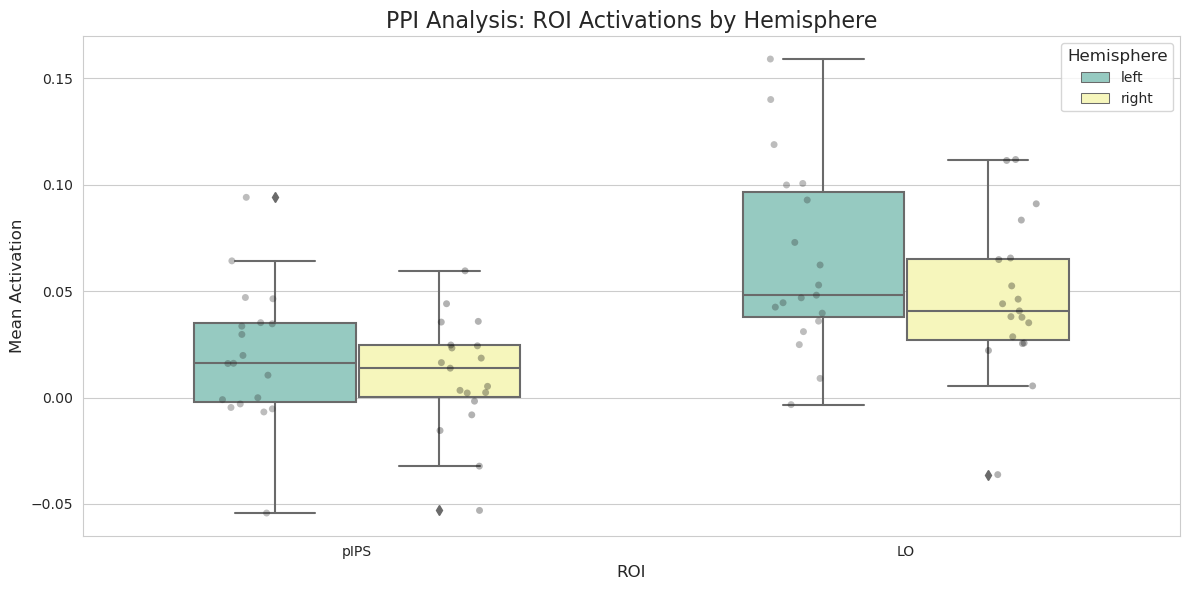

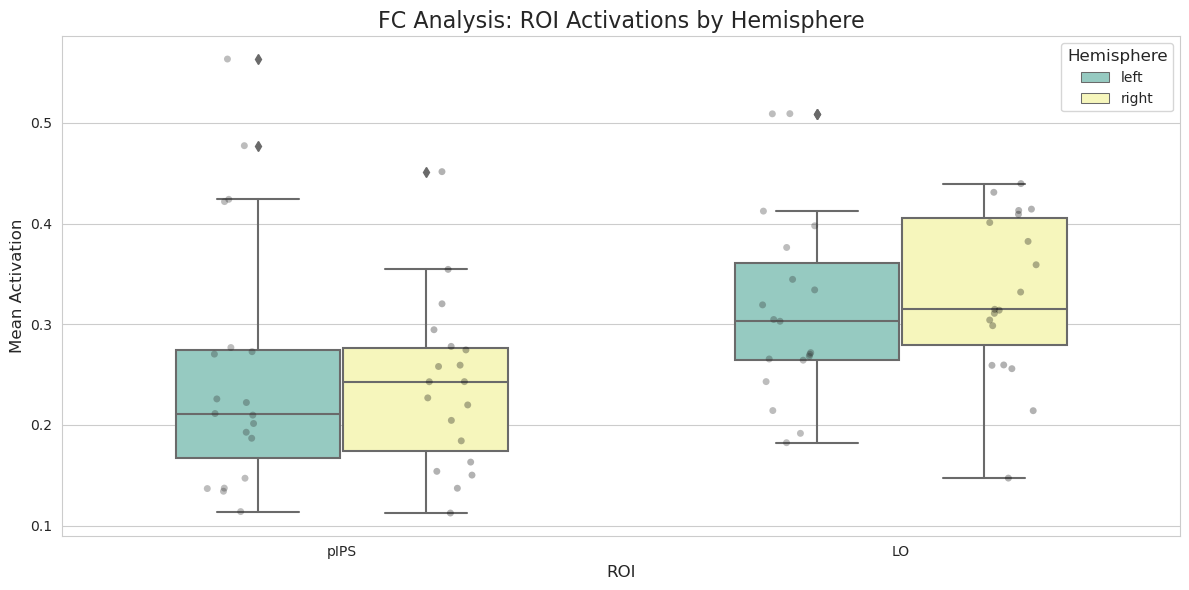

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set up directories
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
results_dir = '/user_data/csimmon2/git_repos/ptoc/results/roi_analysis'

# Load the data
data_path = os.path.join(results_dir, 'roi_mean_activations.csv')
data = pd.read_csv(data_path)

# Create a function to generate the plot
def create_boxplot(data, analysis_type):
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    
    # Create the box plot
    sns.boxplot(x='roi', y='mean_activation', hue='hemisphere', 
                data=data[data['analysis'] == analysis_type],
                palette='Set3', width=0.6)
    
    # Customize the plot
    plt.title(f'{analysis_type.upper()} Analysis: ROI Activations by Hemisphere', fontsize=16)
    plt.xlabel('ROI', fontsize=12)
    plt.ylabel('Mean Activation', fontsize=12)
    plt.legend(title='Hemisphere', title_fontsize='12', fontsize='10')
    
    # Add individual data points
    sns.stripplot(x='roi', y='mean_activation', hue='hemisphere', 
                  data=data[data['analysis'] == analysis_type],
                  dodge=True, alpha=0.3, color='black')
    
    # Remove legend for stripplot
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:2], labels[:2], title='Hemisphere', title_fontsize='12', fontsize='10')
    
    plt.tight_layout()
    output_path = os.path.join(results_dir, f'{analysis_type}_roi_activations.png')
    #plt.savefig(output_path, dpi=300)
    #plt.close()

# Generate plots for both PPI and FC analyses
create_boxplot(data, 'ppi')
create_boxplot(data, 'fc')

print(f"Plots have been saved in the directory: {results_dir}")
print("Files: 'ppi_roi_activations.png' and 'fc_roi_activations.png'")

In [16]:
import pandas as pd
import numpy as np
from plotnine import (ggplot, aes, geom_point, geom_linerange, theme_classic, 
                      ylim, xlab, ylab, ggtitle, theme, element_text, element_line, 
                      element_blank, scale_color_manual, position_dodge2, 
                      geom_hline, scale_shape_manual, labs, facet_wrap)
import os
from scipy import stats

# Set up directories
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
results_dir = '/user_data/csimmon2/git_repos/ptoc/results/roi_analysis'

# Load the data
data_path = os.path.join(results_dir, 'roi_mean_activations.csv')
data = pd.read_csv(data_path)

def create_plot(data, analysis_type):
    # Create a new column combining hemisphere and ROI
    data['region'] = data['hemisphere'] + data['roi']
    
    # Create summary dataframe
    summary_df = data[data['analysis'] == analysis_type].groupby('region').agg({
        'mean_activation': ['mean', 'sem']
    }).reset_index()
    summary_df.columns = ['region', 'mean', 'se']

    # Ensure consistent ordering
    region_order = ['leftpIPS', 'leftLO', 'rightpIPS', 'rightLO']
    summary_df['region'] = pd.Categorical(summary_df['region'], categories=region_order, ordered=True)
    summary_df = summary_df.sort_values('region')

    # Set appropriate y-axis label
    if analysis_type == 'fc':
        y_label = 'Functional Connectivity'
        title = 'FC Analysis: ROI Functional Connectivity'
    elif analysis_type == 'ppi':
        y_label = 'PPI Connectivity'
        title = 'PPI Analysis: ROI Connectivity with Psychological Regressor'

    # Create the plot
    plot = (ggplot(summary_df, aes(x='region', y='mean', color='region', shape='region'))
            + geom_linerange(aes(ymin='mean - se', ymax='mean + se'), 
                             size=1, position=position_dodge2(width=0.5))
            + geom_point(size=4, fill='white', stroke=1, 
                         position=position_dodge2(width=0.5))
            + scale_color_manual(values=['#31688E', '#440154', '#31688E', '#440154'])
            + scale_shape_manual(values=['o', 's', 'o', 's'])
            + theme_classic()
            + labs(color='Region', shape='Region')
            + xlab('Region')
            + ylab(y_label)
            + ggtitle(title)
            + theme(
                text=element_text(color='black'),
                axis_text_x=element_text(angle=45, hjust=1, size=12),
                axis_text_y=element_text(size=12),
                axis_title=element_text(size=14),
                plot_title=element_text(size=16),
                axis_line=element_line(),
                panel_border=element_blank(),
                legend_position="none",
                figure_size=(10, 6)
            ))

    # Save the plot
    output_path = os.path.join(results_dir, f'{analysis_type}_roi_connectivity.png')
    plot.save(output_path, dpi=300, bbox_inches='tight')
    print(f"{analysis_type.upper()} plot has been saved as: {output_path}")

    # Perform statistical tests
    stats_results = []
    for roi in ['pIPS', 'LO']:
        left_data = data[(data['analysis'] == analysis_type) & (data['roi'] == roi) & (data['hemisphere'] == 'left')]['mean_activation']
        right_data = data[(data['analysis'] == analysis_type) & (data['roi'] == roi) & (data['hemisphere'] == 'right')]['mean_activation']
        t_stat, p_val = stats.ttest_rel(left_data, right_data)
        effect_size = (left_data.mean() - right_data.mean()) / np.sqrt((left_data.var() + right_data.var()) / 2)
        stats_results.append({
            'analysis': analysis_type,
            'roi': roi,
            'mean_diff': left_data.mean() - right_data.mean(),
            't_stat': t_stat,
            'p_value': p_val,
            'effect_size': effect_size
        })

    # Create and save summary table
    summary_table = pd.DataFrame(stats_results)
    summary_table_path = os.path.join(results_dir, f'{analysis_type}_summary_stats.csv')
    summary_table.to_csv(summary_table_path, index=False)
    print(f"{analysis_type.upper()} summary statistics have been saved to: {summary_table_path}")

# Generate plots for both PPI and FC analyses
create_plot(data, 'ppi')
create_plot(data, 'fc')

print(f"All plots and summary statistics have been saved in the directory: {results_dir}")

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 10 x 6 in image.
/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /user_data/csimmon2/git_repos/ptoc/results/roi_analysis/ppi_roi_connectivity.png


PPI plot has been saved as: /user_data/csimmon2/git_repos/ptoc/results/roi_analysis/ppi_roi_connectivity.png
PPI summary statistics have been saved to: /user_data/csimmon2/git_repos/ptoc/results/roi_analysis/ppi_summary_stats.csv


/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 10 x 6 in image.
/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /user_data/csimmon2/git_repos/ptoc/results/roi_analysis/fc_roi_connectivity.png


FC plot has been saved as: /user_data/csimmon2/git_repos/ptoc/results/roi_analysis/fc_roi_connectivity.png
FC summary statistics have been saved to: /user_data/csimmon2/git_repos/ptoc/results/roi_analysis/fc_summary_stats.csv
All plots and summary statistics have been saved in the directory: /user_data/csimmon2/git_repos/ptoc/results/roi_analysis


/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


Plots have been saved in the directory: /user_data/csimmon2/git_repos/ptoc/results/roi_analysis
Files: 'ppi_roi_activations.png' and 'fc_roi_activations.png'


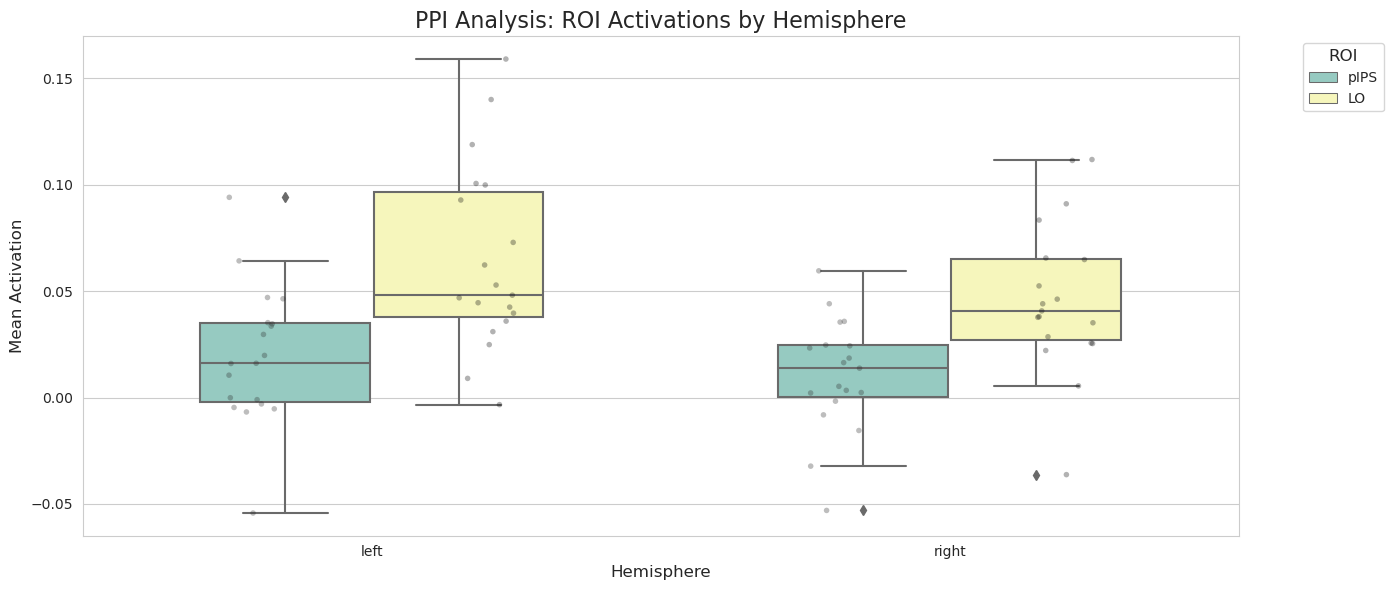

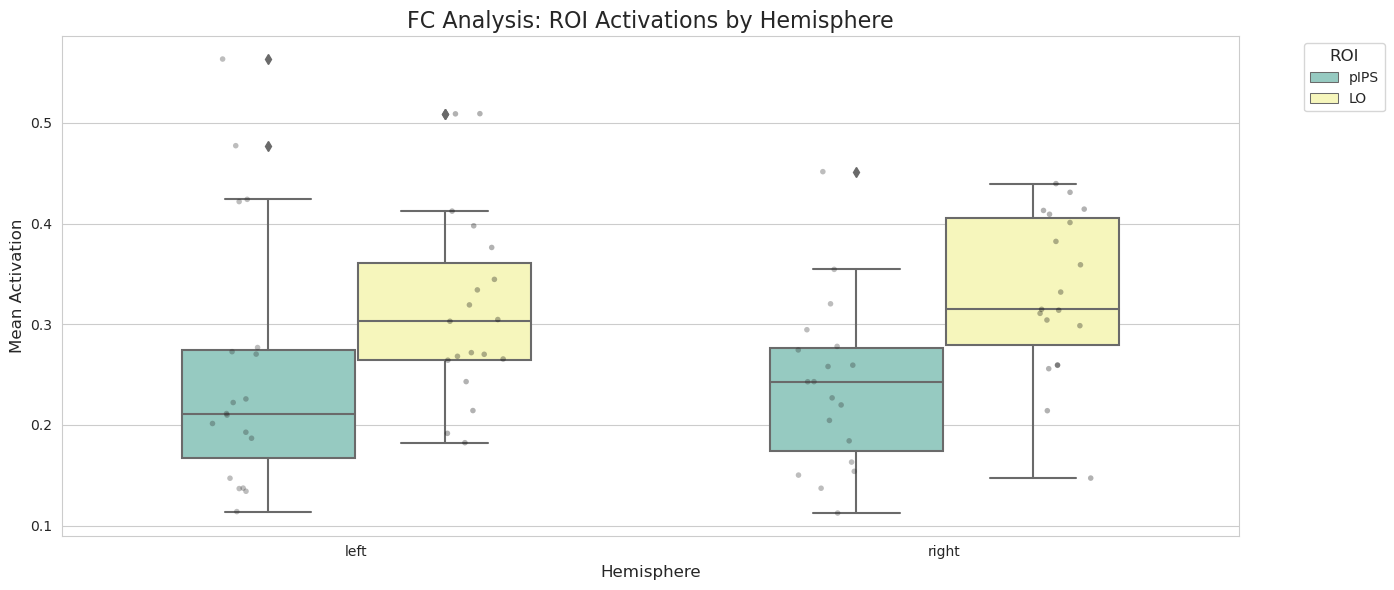

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set up directories
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
results_dir = '/user_data/csimmon2/git_repos/ptoc/results/roi_analysis'

# Load the data
data_path = os.path.join(results_dir, 'roi_mean_activations.csv')
data = pd.read_csv(data_path)

# Create a function to generate the plot
def create_boxplot(data, analysis_type):
    plt.figure(figsize=(14, 6))
    sns.set_style("whitegrid")
    
    # Filter data for the specific analysis
    plot_data = data[data['analysis'] == analysis_type]
    
    # Create the box plot
    sns.boxplot(x='hemisphere', y='mean_activation', hue='roi', 
                data=plot_data, palette='Set3', width=0.6)
    
    # Add individual data points
    sns.stripplot(x='hemisphere', y='mean_activation', hue='roi', 
                  data=plot_data, dodge=True, alpha=0.3, 
                  color='black', size=4)
    
    # Customize the plot
    plt.title(f'{analysis_type.upper()} Analysis: ROI Activations by Hemisphere', fontsize=16)
    plt.xlabel('Hemisphere', fontsize=12)
    plt.ylabel('Mean Activation', fontsize=12)
    
    # Adjust legend
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:2], labels[:2], title='ROI', title_fontsize='12', fontsize='10', 
               bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    output_path = os.path.join(results_dir, f'{analysis_type}_roi_activations.png')
    #plt.savefig(output_path, dpi=300, bbox_inches='tight')
    #plt.close()

# Generate plots for both PPI and FC analyses
create_boxplot(data, 'ppi')
create_boxplot(data, 'fc')

print(f"Plots have been saved in the directory: {results_dir}")
print("Files: 'ppi_roi_activations.png' and 'fc_roi_activations.png'")

Column names in the dataframe:
Index(['lpIPS-lLO', 'lpIPS-rLO', 'rpIPS-lLO', 'rpIPS-rLO'], dtype='object')

First few rows of the dataframe:
         lpIPS-lLO  lpIPS-rLO  rpIPS-lLO  rpIPS-rLO
sub                                                
sub-025   6.542707   3.976337  -0.273055  -5.516101
sub-038  36.221112   6.748750   5.041650   0.858832
sub-057   1.978192  33.322356   3.193565  21.792058
sub-059   7.953541   1.820534   0.604075 -19.537321
sub-064   1.015321   3.283093   1.859057   4.341189

ROI comparison plot has been saved to /user_data/csimmon2/git_repos/ptoc/results/gca/roi_comparisons.png

Paired t-test results for lpIPS-lLO vs rpIPS-lLO:
t-statistic: 2.892572464178214
p-value: 0.009699711497479016

Paired t-test results for lpIPS-rLO vs rpIPS-rLO:
t-statistic: 3.165709233510401
p-value: 0.005350708723379199

ROI comparison results have been saved to /user_data/csimmon2/git_repos/ptoc/results/gca/roi_comparison_results.txt


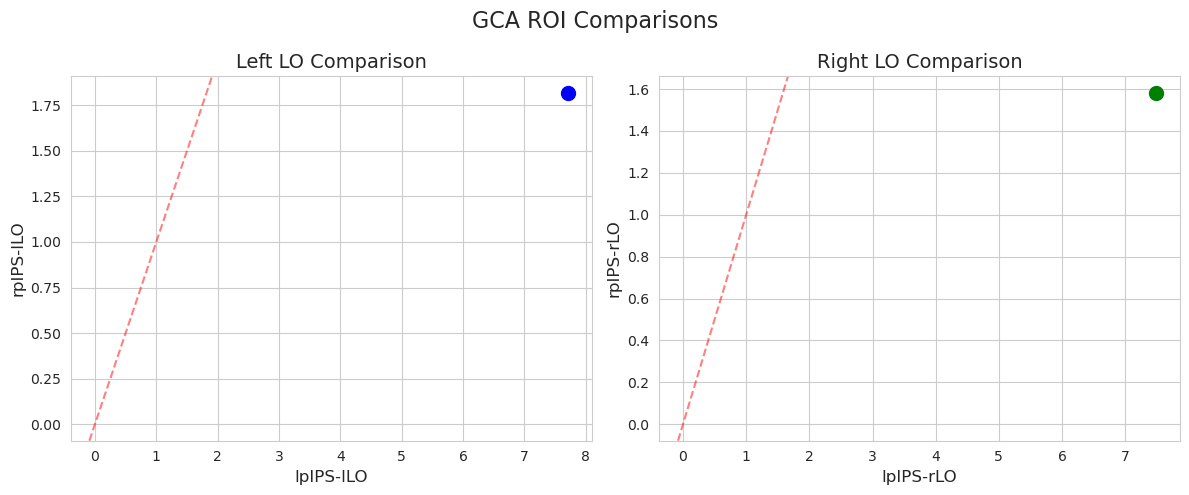

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# File path
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
input_file = f"{results_dir}/gca/subject_roi_pair_summary.csv"

# Read the CSV file
df = pd.read_csv(input_file)

# Set the 'sub' column as the index
df.set_index('sub', inplace=True)

# Print column names
print("Column names in the dataframe:")
print(df.columns)

# Print the first few rows of the dataframe
print("\nFirst few rows of the dataframe:")
print(df.head())

def create_comparison_plots(data):
    # Calculate means across subjects
    means = data.mean()
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('GCA ROI Comparisons', fontsize=16)
    
    # Plot 1: lpIPS-lLO vs rpIPS-lLO
    ax1.scatter(means['lpIPS-lLO'], means['rpIPS-lLO'], s=100, color='blue')
    ax1.set_xlabel('lpIPS-lLO', fontsize=12)
    ax1.set_ylabel('rpIPS-lLO', fontsize=12)
    ax1.set_title('Left LO Comparison', fontsize=14)
    ax1.axline((0, 0), slope=1, color='red', linestyle='--', alpha=0.5)  # Add y=x line
    
    # Plot 2: lpIPS-rLO vs rpIPS-rLO
    ax2.scatter(means['lpIPS-rLO'], means['rpIPS-rLO'], s=100, color='green')
    ax2.set_xlabel('lpIPS-rLO', fontsize=12)
    ax2.set_ylabel('rpIPS-rLO', fontsize=12)
    ax2.set_title('Right LO Comparison', fontsize=14)
    ax2.axline((0, 0), slope=1, color='red', linestyle='--', alpha=0.5)  # Add y=x line
    
    plt.tight_layout()
    output_path = f"{results_dir}/gca/roi_comparisons.png"
    #plt.savefig(output_path, dpi=300, bbox_inches='tight')
    #plt.close()

# Generate plots
create_comparison_plots(df)

print(f"\nROI comparison plot has been saved to {results_dir}/gca/roi_comparisons.png")

# Perform paired t-tests
t_stat_lLO, p_val_lLO = stats.ttest_rel(df['lpIPS-lLO'], df['rpIPS-lLO'])
print("\nPaired t-test results for lpIPS-lLO vs rpIPS-lLO:")
print(f"t-statistic: {t_stat_lLO}")
print(f"p-value: {p_val_lLO}")

t_stat_rLO, p_val_rLO = stats.ttest_rel(df['lpIPS-rLO'], df['rpIPS-rLO'])
print("\nPaired t-test results for lpIPS-rLO vs rpIPS-rLO:")
print(f"t-statistic: {t_stat_rLO}")
print(f"p-value: {p_val_rLO}")

# Save the comparison results
with open(f"{results_dir}/gca/roi_comparison_results.txt", 'w') as f:
    f.write("ROI Comparison Results:\n\n")
    f.write(f"lpIPS-lLO vs rpIPS-lLO:\n")
    f.write(f"t-statistic: {t_stat_lLO}\n")
    f.write(f"p-value: {p_val_lLO}\n\n")
    f.write(f"lpIPS-rLO vs rpIPS-rLO:\n")
    f.write(f"t-statistic: {t_stat_rLO}\n")
    f.write(f"p-value: {p_val_rLO}\n")

print(f"\nROI comparison results have been saved to {results_dir}/gca/roi_comparison_results.txt")

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats

# Set up directories
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
results_dir = '/user_data/csimmon2/git_repos/ptoc/results/roi_analysis'

# Load the data
data_path = os.path.join(results_dir, 'roi_mean_activations.csv')
data = pd.read_csv(data_path)

# Create a function to generate the plot
def create_boxplot(data, analysis_type):
    plt.figure(figsize=(14, 6))
    sns.set_style("whitegrid")
    
    # Filter data for the specific analysis
    plot_data = data[data['analysis'] == analysis_type]
    
    # Create the box plot
    sns.boxplot(x='hemisphere', y='mean_activation', hue='roi', 
                data=plot_data, palette='Set3', width=0.6)
    
    # Add individual data points
    sns.stripplot(x='hemisphere', y='mean_activation', hue='roi', 
                  data=plot_data, dodge=True, alpha=0.3, 
                  color='black', size=4)
    
    # Customize the plot
    plt.title(f'{analysis_type.upper()} Analysis: ROI Activations by Hemisphere', fontsize=16)
    plt.xlabel('Hemisphere', fontsize=12)
    plt.ylabel('Mean Activation', fontsize=12)
    
    # Adjust legend
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:2], labels[:2], title='ROI', title_fontsize='12', fontsize='10', 
               bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    output_path = os.path.join(results_dir, f'{analysis_type}_roi_activations.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

# Function to perform t-test
def perform_ttest(data, analysis_type):
    # Filter data for the specific analysis
    analysis_data = data[data['analysis'] == analysis_type]
    
    # Separate data for left and right hemispheres
    left_hemisphere = analysis_data[analysis_data['hemisphere'] == 'left']['mean_activation']
    right_hemisphere = analysis_data[analysis_data['hemisphere'] == 'right']['mean_activation']
    
    # Perform t-test
    t_statistic, p_value = stats.ttest_ind(left_hemisphere, right_hemisphere)
    
    print(f"\nT-test results for {analysis_type.upper()} analysis:")
    print(f"T-statistic: {t_statistic}")
    print(f"P-value: {p_value}")
    
    # Interpret the results
    alpha = 0.05
    if p_value < alpha:
        print(f"The difference between left and right hemispheres is statistically significant (p < {alpha}).")
    else:
        print(f"There is no statistically significant difference between left and right hemispheres (p >= {alpha}).")

# Generate plots and perform t-tests for both PPI and FC analyses
for analysis in ['ppi', 'fc']:
    create_boxplot(data, analysis)
    perform_ttest(data, analysis)

print(f"\nPlots have been saved in the directory: {results_dir}")
print("Files: 'ppi_roi_activations.png' and 'fc_roi_activations.png'")

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)



T-test results for PPI analysis:
T-statistic: 1.4176298962709162
P-value: 0.16049591891442877
There is no statistically significant difference between left and right hemispheres (p >= 0.05).


/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)



T-test results for FC analysis:
T-statistic: 0.02007197350624155
P-value: 0.9840399805910764
There is no statistically significant difference between left and right hemispheres (p >= 0.05).

Plots have been saved in the directory: /user_data/csimmon2/git_repos/ptoc/results/roi_analysis
Files: 'ppi_roi_activations.png' and 'fc_roi_activations.png'


In [2]:
##create wide format df

import pandas as pd
import os


# Read the data
data = pd.read_csv('/user_data/csimmon2/git_repos/ptoc/results/roi_analysis/roi_mean_activations.csv')

# Pivot the data
wide_data = data.pivot(index=['subject', 'task'], 
                       columns=['hemisphere', 'roi', 'analysis'], 
                       values='mean_activation')

# Flatten the column names
wide_data.columns = [f"{hemi}_{roi}_{analysis}" for (hemi, roi, analysis) in wide_data.columns]

# Reset the index to make 'subject' and 'task' regular columns
wide_data = wide_data.reset_index()

# Sort the columns alphabetically (except 'subject' and 'task')
sorted_cols = ['subject', 'task'] + sorted([col for col in wide_data.columns if col not in ['subject', 'task']])
wide_data = wide_data[sorted_cols]

# Display the first few rows of the transformed data
print(wide_data.head())

# Create the directory if it doesn't exist
os.makedirs(os.path.join(results_dir, "fc_ppi"), exist_ok=True)

# Save the transformed data to the specified CSV file
output_file = os.path.join(results_dir, "fc_ppi", "roi_mean_activations_wide.csv")
wide_data.to_csv(output_file, index=False)

print(f"Data saved to: {output_file}")

# Verify that the file can be read back
df = pd.read_csv(output_file)
print("\nVerifying the saved data:")
print(df.head())

   subject task  left_LO_fc  left_LO_ppi  left_pIPS_fc  left_pIPS_ppi  \
0  sub-025  loc    0.302970     0.030980      0.136840       0.035204   
1  sub-038  loc    0.319214     0.099914      0.270358       0.046428   
2  sub-057  loc    0.509103     0.092850      0.477317       0.064247   
3  sub-059  loc    0.304702     0.062307      0.424044      -0.000994   
4  sub-064  loc    0.344571     0.048119      0.201444      -0.006783   

   right_LO_fc  right_LO_ppi  right_pIPS_fc  right_pIPS_ppi  
0     0.310822      0.025617       0.320304        0.035801  
1     0.409222      0.064855       0.150216        0.003380  
2     0.431014      0.065590       0.354495       -0.008143  
3     0.255879      0.035145       0.274509        0.059562  
4     0.259216      0.028568       0.112554       -0.015502  
Data saved to: results/fc_ppi/roi_mean_activations_wide.csv

Verifying the saved data:
   subject task  left_LO_fc  left_LO_ppi  left_pIPS_fc  left_pIPS_ppi  \
0  sub-025  loc    0.302970  

In [6]:
"""
plot PPI
"""
analysis = 'ppi' #consider fc
dorsal_rois =  ['left_pIPS_ppi', 'right_pIPS_ppi'] ## check names
ventral_rois = ['left_LO_ppi', 'right_LO_ppi'] ## check names
roi_names = ['Left pIPS', 'Right pIPS', 'Left LO','Right LO']
roi_pos = ['posterior', 'posterior', 'lateral', 'lateral']

for rr in ventral_rois:

    summary_df = pd.DataFrame(columns = ["ROI",'LOC' "FC", "SE"])
    summary_df['ROI'] = roi_names
    summary_df['LOC'] = roi_pos

    df = pd.read_csv(f"{results_dir}/fc_ppi/roi_mean_activations_wide.csv")
    df = df[dorsal_rois]
    
    #df.columns = cond_names
    summary_df['FC'] = df.mean().to_list()
    summary_df['SE'] = df.sem().to_list()

    summary_df['ROI'] = pd.Categorical(summary_df['ROI'], categories = roi_names, ordered = False)

    plot = ggplot(summary_df, aes(x='ROI', y='FC',color = 'LOC')) + geom_linerange(aes(x='ROI',  ymax = f'FC + SE', ymin = f'FC - SE'), size = 1) + \
            geom_point(shape = 'o', size = 4, fill = 'White', stroke = 1) + ylim(0, .04) + \
            theme_classic() + xlab('Seed Region') + ylab('Functional Connectivity \n(Fisher-Z)') + \
                scale_color_manual(values = [ '#33B778', '#31688E','#440154']) + \
                theme(text = element_text(color ='black'), axis_text_x= element_text(angle = 30, size = 12),axis_text_y= element_text(size = 12),axis_title=element_text(size = 14),
                                                                                axis_line=element_line(), 
                                                                                panel_border=element_blank(),
                                                                                legend_position = "none",
                                                                                figure_size = (4, 5))

    print(plot)

ValueError: Length of values (2) does not match length of index (4)

/tmp/ipykernel_38853/1712725304.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_38853/1712725304.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_38853/1712725304.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


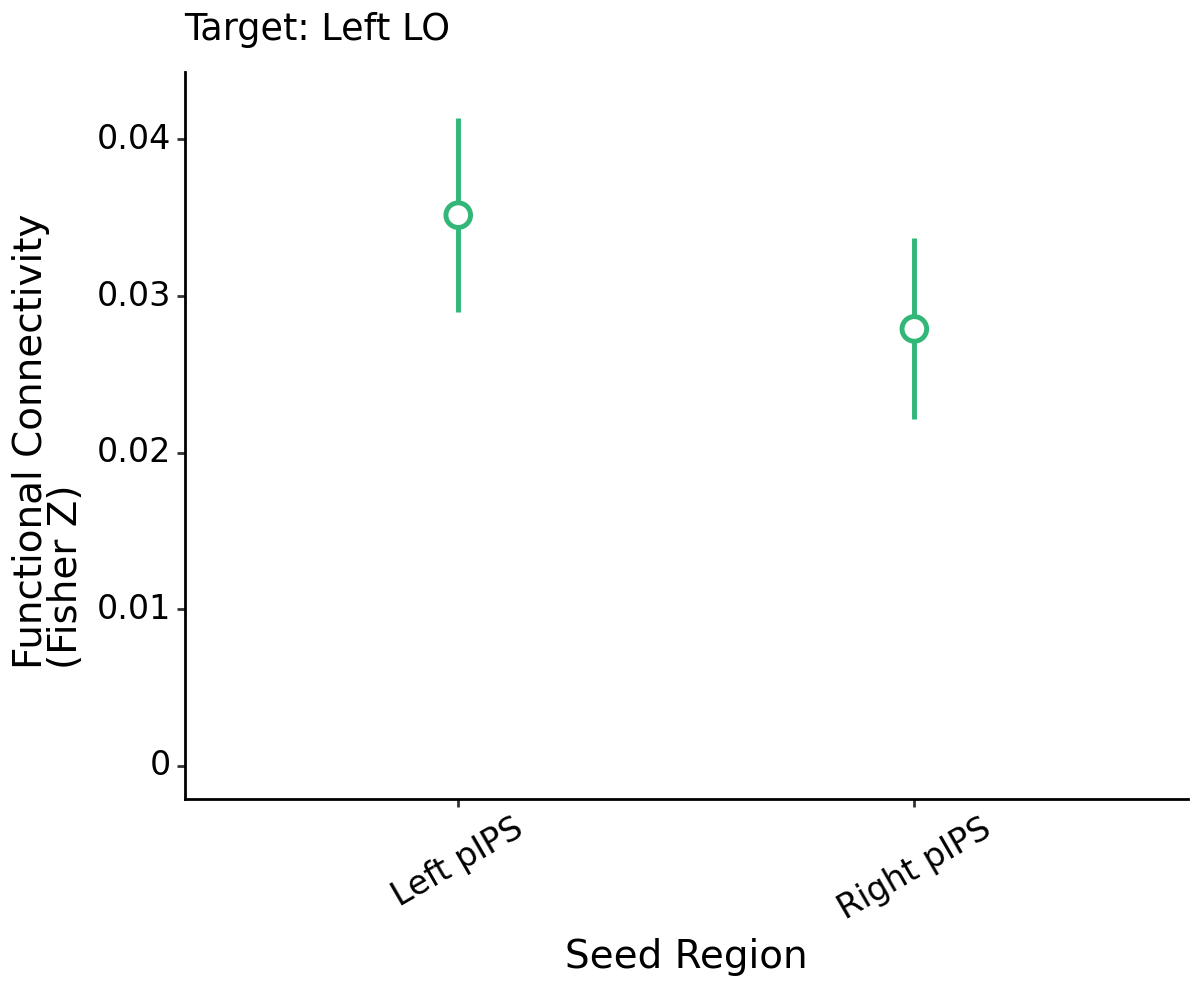

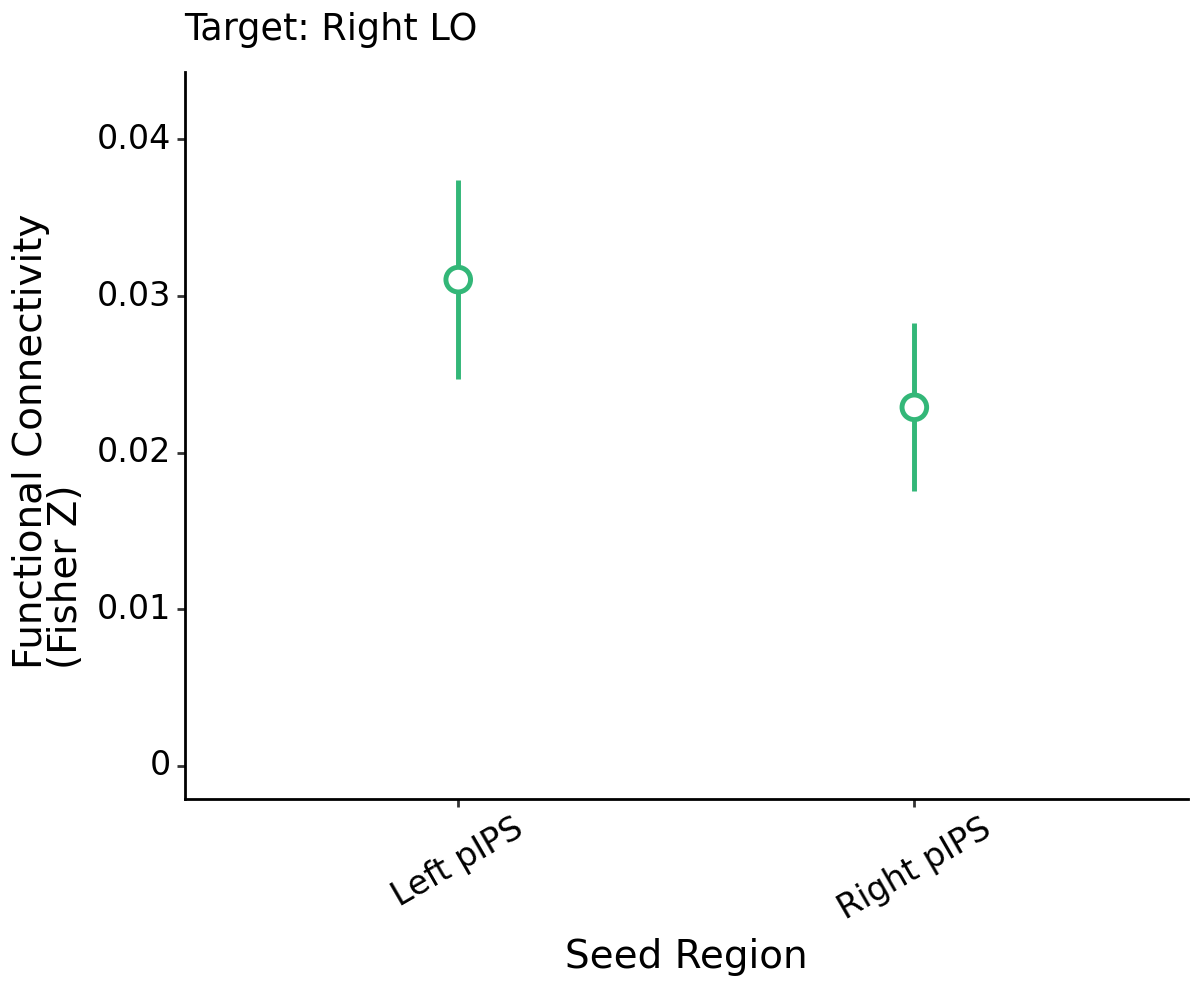

In [17]:
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_linerange, geom_point, ylim, theme_classic, xlab, ylab, scale_color_manual, theme, element_text, element_line, element_blank, facet_wrap, ggtitle

# Define variables
analysis = 'ppi'
results_dir = "results"  # Update this to your actual results directory

# Read the data
df = pd.read_csv(f"{results_dir}/fc_ppi/matchvlad_seed_target_activations.csv")

# Filter for the 'loc' task and 'ppi' analysis
df_filtered = df[(df['task'] == 'loc') & (df['analysis'] == 'ppi')]

# Create seed and target columns
df_filtered['seed'] = df_filtered['seed_hemisphere'] + '_' + df_filtered['seed_roi']
df_filtered['target'] = df_filtered['target_hemisphere'] + '_' + df_filtered['target_roi']

# Apply Fisher z-transform
df_filtered['fisher_z'] = np.arctanh(df_filtered['mean_activation'])

# Group by seed and target, calculate mean and standard error of Fisher z values
summary_df = df_filtered.groupby(['seed', 'target'])['fisher_z'].agg(['mean', 'sem']).reset_index()

# Rename columns
summary_df.columns = ['Seed', 'Target', 'FC', 'SE']

# Add LOC column for seeds
summary_df['LOC'] = 'posterior'  # All seeds are pIPS, which is posterior

# Rename ROIs for better readability
seed_mapping = {
    'left_pIPS': 'Left pIPS',
    'right_pIPS': 'Right pIPS'
}
target_mapping = {
    'left_LO': 'Left LO',
    'right_LO': 'Right LO'
}
summary_df['Seed'] = summary_df['Seed'].map(seed_mapping)
summary_df['Target'] = summary_df['Target'].map(target_mapping)

# Set Seed as categorical
summary_df['Seed'] = pd.Categorical(summary_df['Seed'], categories=['Left pIPS', 'Right pIPS'], ordered=False)

# Function to create plot for a specific target
def create_plot(data, target):
    plot = (ggplot(data[data['Target'] == target], aes(x='Seed', y='FC', color='LOC'))
            + geom_linerange(aes(ymax='FC + SE', ymin='FC - SE'), size=1)
            + geom_point(shape='o', size=4, fill='white', stroke=1)
            + ylim(0, data['FC'].max() * 1.2)  # Adjust ylim based on data
            + theme_classic()
            + xlab('Seed Region')
            + ylab('Functional Connectivity \n(Fisher Z)')
            + scale_color_manual(values=['#33B778'])
            + theme(
                text=element_text(color='black'),
                axis_text_x=element_text(angle=30, size=12),
                axis_text_y=element_text(size=12),
                axis_title=element_text(size=14),
                axis_line=element_line(),
                panel_border=element_blank(),
                legend_position="none",
                figure_size=(6, 5)
            )
            + ggtitle(f'Target: {target}'))
    return plot

# Create and print plots
left_lo_plot = create_plot(summary_df, 'Left LO')
right_lo_plot = create_plot(summary_df, 'Right LO')

print(left_lo_plot)
print(right_lo_plot)

# Optionally, save the plots
# left_lo_plot.save("left_lo_ppi_plot.png", dpi=300)
# right_lo_plot.save("right_lo_ppi_plot.png", dpi=300)